In [1]:
import networkx as nx
import gurobipy as gp
import matplotlib.pyplot as plt
from gurobipy import GRB

In [2]:
import osmnx as ox

%matplotlib inline
ox.__version__

'1.3.0'

## Download Genova network map

In [3]:
totG = ox.graph_from_place('Genova, Liguria, Italy', network_type="drive")
ox.save_graphml(totG, filepath="wholegenova.graphml", gephi=True,encoding="utf-8")

## Read graph from Neo4j

After import wholegenova.graphml in Neo4j and do a preprosessing data, export the graph and read the new wholegenovaExport.graphml

In [2]:
G = nx.read_graphml("wholegenovaExport.graphml")

/Users/laudie/opt/anaconda3/envs/socialMining/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1031: UserWarning: No key type for id coordinates. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/Users/laudie/opt/anaconda3/envs/socialMining/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1031: UserWarning: No key type for id labels. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/Users/laudie/opt/anaconda3/envs/socialMining/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1031: UserWarning: No key type for id junction. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/Users/laudie/opt/anaconda3/envs/socialMining/lib/python3.9/site-packages/networkx/readwrite/graphml.py:1031: UserWarning: No key type for id area. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/Users/laudie/opt/anaconda3/envs/socialMining/lib/python3.9/site-packages/networkx/readwrit

In [3]:
for u, v, attr in G.edges(data=True):
    attr['length'] = float(attr['length'])  # Conversione del peso in un valore numerico

In [4]:
shortest_paths = nx.all_pairs_dijkstra_path_length(G, weight='length')

In [5]:
shortest_paths = dict(shortest_paths)  

In [7]:
import pickle
with open('shortest_paths_reachability_graph.pickle', 'wb') as f:
    pickle.dump(shortest_paths, f)

In [10]:
shortest_paths['n0']['n16']

979.624

In [11]:
# Inizializza il grafo RG vuoto
reach_graph = nx.DiGraph()

# Itera su tutte le coppie di nodi e verifica la distanza
for node1 in G.nodes():
    for node2 in G.nodes():
        if node1 != node2:
            try:
                if shortest_paths[node1][node2]:
                    distance = shortest_paths[node1][node2]  # Ottieni la distanza tra i nodi
                    if distance <= 3000:
                        reach_graph.add_edge(node1, node2, weight=distance)  # Aggiungi l'arco con l'attributo di distanza
            except:
                continue



In [12]:
reach_graph.number_of_edges()

6110142

In [13]:
nx.write_graphml_lxml(reach_graph, "reach_graph_all_pairs.graphml")

Database Neo4j nome ReachabilityWholeGenova

dump del database: reachability-whole-genova-neo4j-Jun-14-2023-15-15-09.dump

## Leggo grafo di raggiungibilità

In [14]:
reach_graph.get_edge_data('n0', 'n15')

{'weight': 1077.888}

In [15]:
for u, v, attr in reach_graph.edges(data=True):
    attr['weight'] = float(attr['weight'])  # Conversione del peso in un valore numerico

## k-dominating set 

Risolvo modello dell'insieme dominante con k=3. In questo caso ogni nodo non nell'insieme dominante ha 3 vicini nell'insieme dominante. 
Questi nodi rappresentano eventuali siti candidati in quanto sono stazioni di servizio (carburante) o aree di parcheggio

In [16]:
def solve_k_dominating_set(graph, k):
    model = gp.Model("k-dominating-set")

    # Creazione delle variabili di decisione
    dominating_set = model.addVars(graph.nodes, vtype=GRB.BINARY, name="dominating_set")

    # Obiettivo: minimizzare la cardinalità del dominating set
    model.setObjective(dominating_set.sum(), GRB.MINIMIZE)

    # Vincolo: ogni nodo deve essere nel dominating set o avere almeno un vicino nel dominating set
    for node in graph.nodes:
        successors = graph.successors(node)
        model.addConstr(dominating_set[node] + gp.quicksum(dominating_set[neighbor] for neighbor in successors) >= 1)

    # Vincolo: il numero di nodi nel dominating set deve essere almeno k
    model.addConstr(dominating_set.sum() >= k)

    # Risoluzione del modello
    model.optimize()

    if model.status == GRB.OPTIMAL:
        # Estrazione del dominating set ottimo
        dominating_set_solution = [node for node in graph.nodes if dominating_set[node].x > 0.5]
        return dominating_set_solution
    else:
        return None


In [20]:
solve_k_dominating_set(reach_graph, 3)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8978 rows, 8977 columns and 6128096 nonzeros
Model fingerprint: 0x1be121d9
Variable types: 0 continuous, 8977 integer (8977 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 117.0000000
Presolve removed 8978 rows and 8977 columns
Presolve time: 0.91s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 1.10 seconds (1.37 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 92 117 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.200000000000e+01, best bound 9.200000000000e+01, gap 0.0000%


['n299',
 'n408',
 'n834',
 'n1090',
 'n2188',
 'n3743',
 'n8731',
 'n3583',
 'n4457',
 'n7770',
 'n8622',
 'n71',
 'n3155',
 'n6987',
 'n4140',
 'n701',
 'n1517',
 'n798',
 'n4237',
 'n444',
 'n4271',
 'n3305',
 'n926',
 'n532',
 'n1177',
 'n4510',
 'n319',
 'n582',
 'n323',
 'n5513',
 'n925',
 'n1145',
 'n4290',
 'n4487',
 'n340',
 'n5210',
 'n709',
 'n714',
 'n2697',
 'n5842',
 'n613',
 'n5253',
 'n6954',
 'n5734',
 'n5851',
 'n6911',
 'n8447',
 'n635',
 'n876',
 'n4439',
 'n7179',
 'n5473',
 'n913',
 'n4638',
 'n5549',
 'n5879',
 'n5977',
 'n3071',
 'n7513',
 'n1160',
 'n6661',
 'n6674',
 'n1095',
 'n5520',
 'n4866',
 'n6284',
 'n6311',
 'n6538',
 'n4758',
 'n3291',
 'n7072',
 'n6344',
 'n4929',
 'n8128',
 'n3564',
 'n5751',
 'n5821',
 'n5755',
 'n4489',
 'n4694',
 'n4910',
 'n5563',
 'n5338',
 'n5649',
 'n5586',
 'n5542',
 'n5540',
 'n5778',
 'n6790',
 'n5617',
 'n5661',
 'n5942']

In [ ]:
In Neo4j eseguire la seguente query per recuperare i nodi in cui installare le stazioni

WITH ['n299','n408','n834','n1090','n2188','n3743','n8731','n3583','n4457','n7770','n8622','n71','n3155','n6987',
      'n4140','n701','n1517','n798','n4237','n444','n4271','n3305','n926','n532','n1177','n4510','n319','n582',
      'n323','n5513','n925','n1145','n4290','n4487','n340','n5210','n709','n714','n2697','n5842','n613','n5253',
      'n6954','n5734','n5851','n6911','n8447','n635','n876','n4439','n7179','n5473','n913','n4638','n5549','n5879',
      'n5977','n3071','n7513','n1160','n6661','n6674','n1095','n5520','n4866','n6284','n6311','n6538','n4758','n3291',
      'n7072','n6344','n4929','n8128','n3564','n5751','n5821','n5755','n4489','n4694','n4910','n5563','n5338','n5649',
      'n5586','n5542','n5540','n5778','n6790','n5617','n5661','n5942']
 as pd 
UNWIND pd AS singS 
WITH apoc.text.replace(singS,'n','') as id 
MATCH (p:Point) 
WHERE id(p)=toFloat(id) 
SET p:Station
    

## Risultato: 92 stazioni da aprire


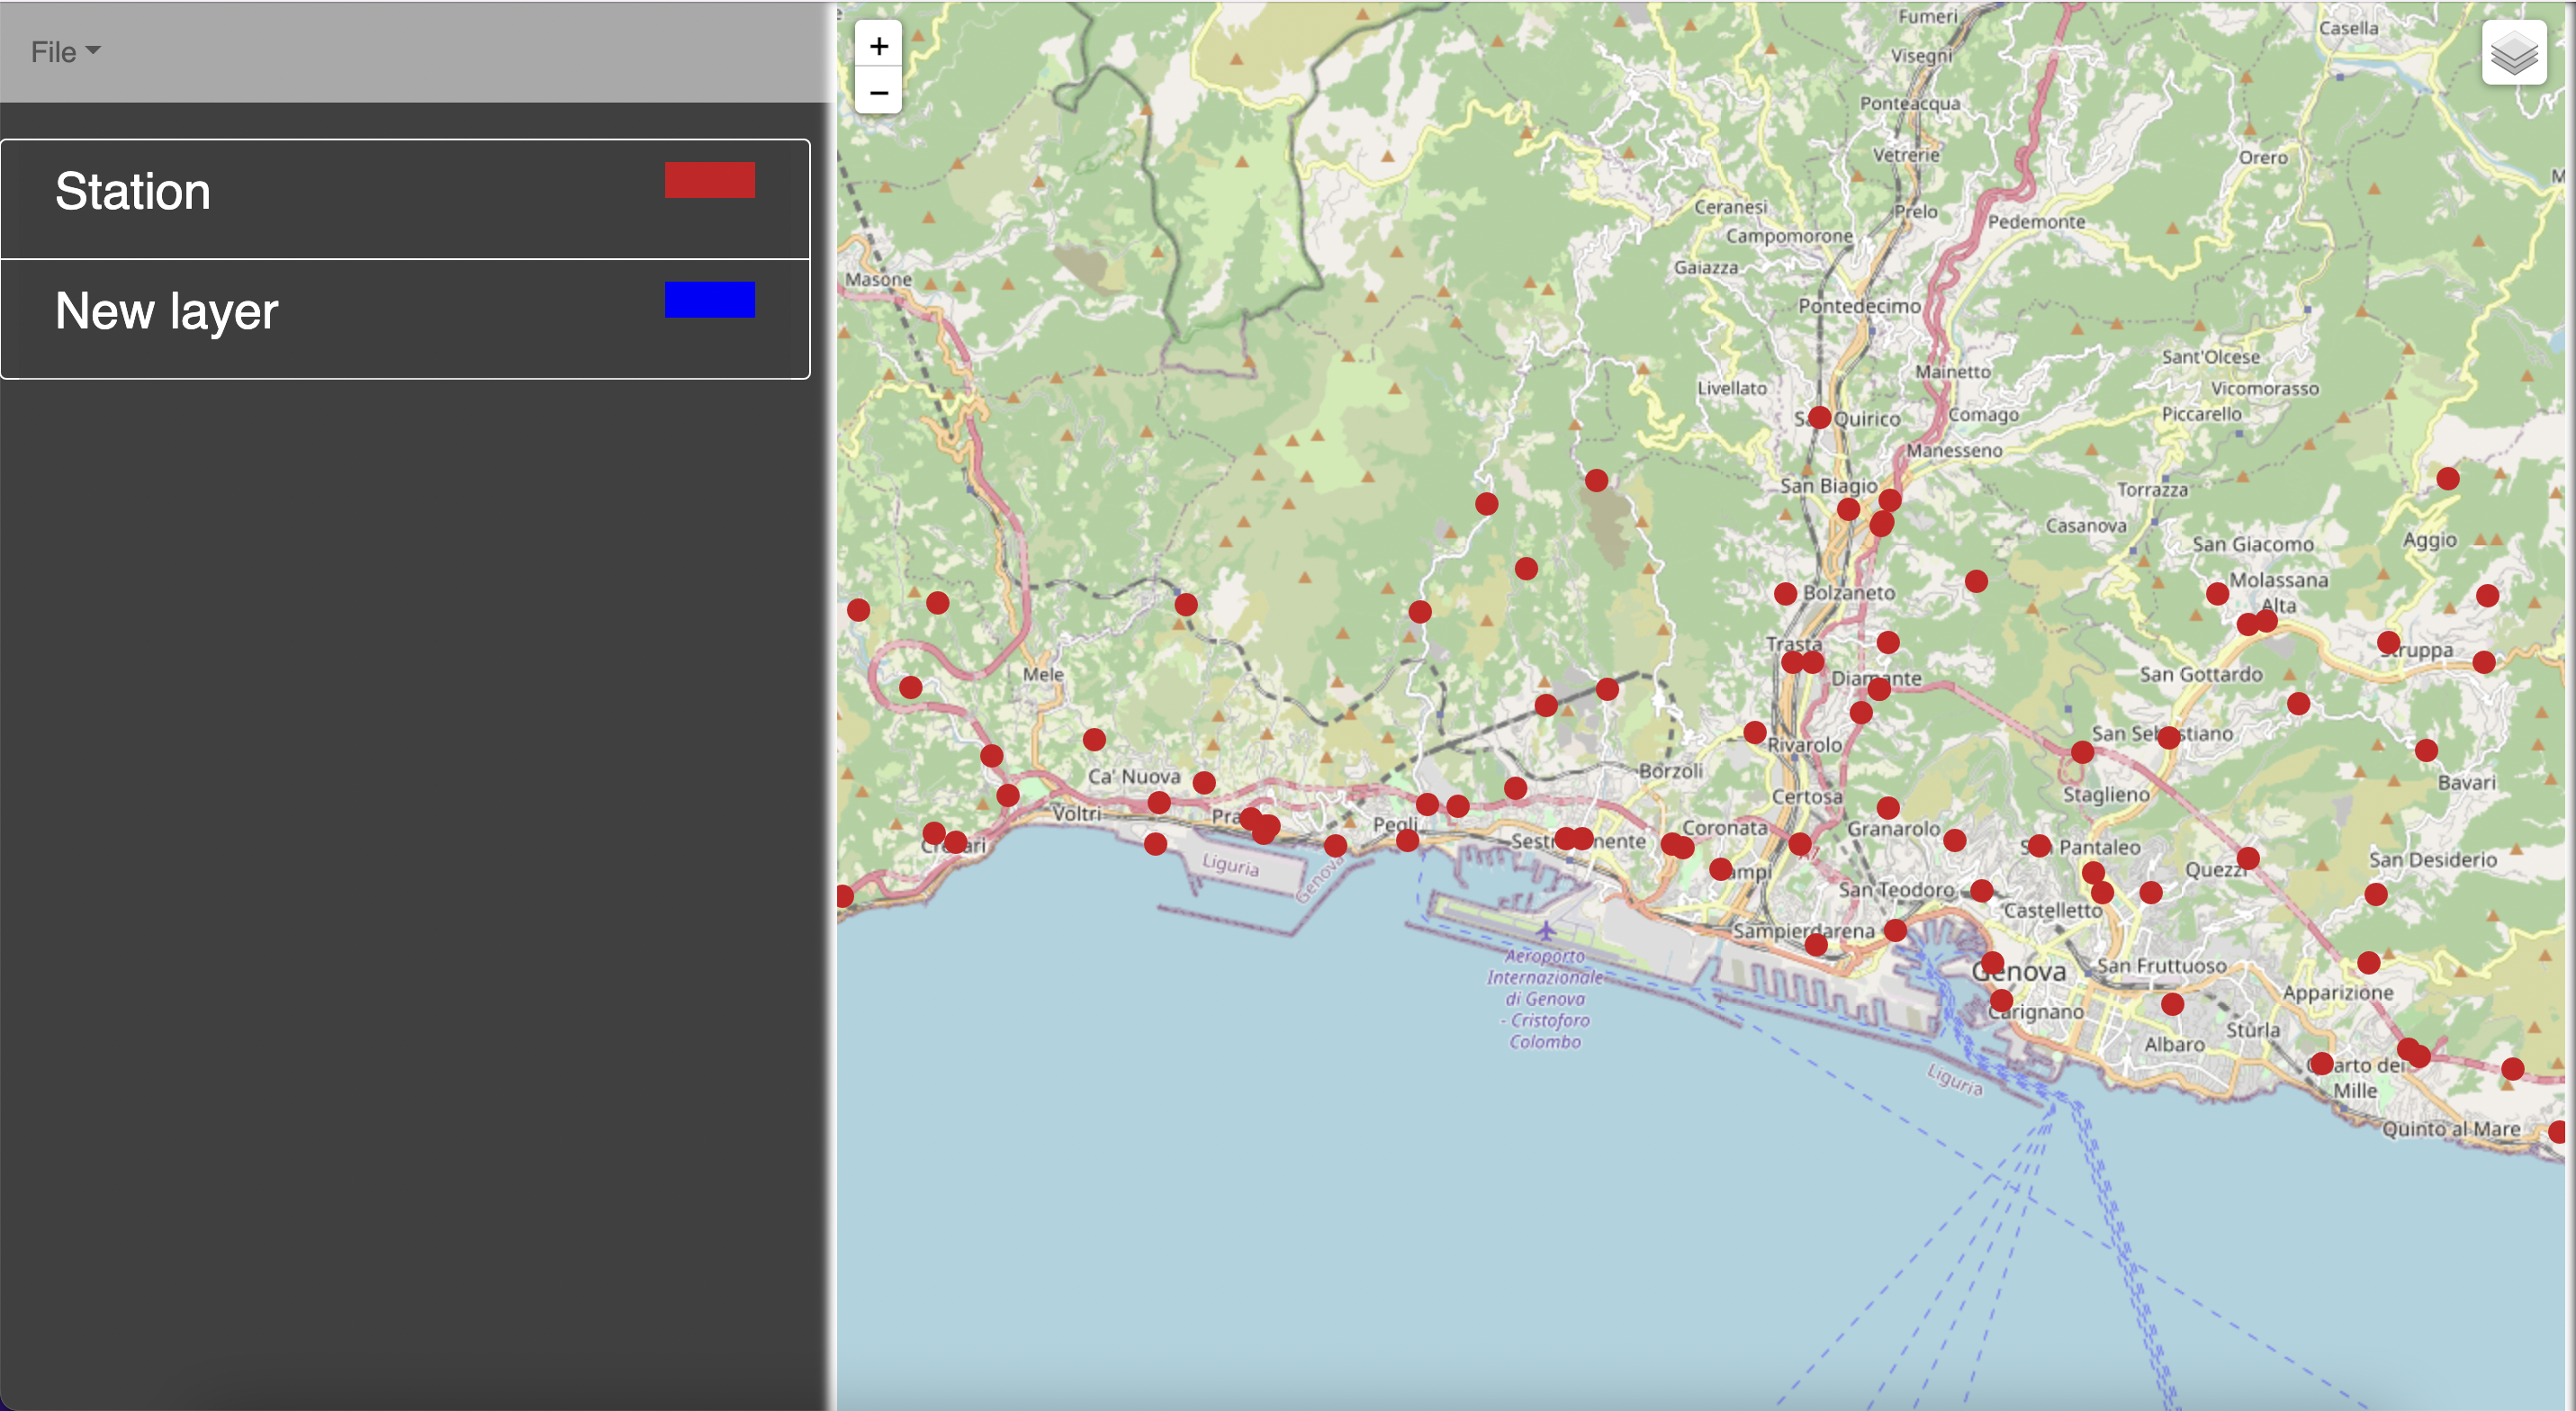